In [1]:
# Import necessary libraries
from pathlib import Path
import os 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Datapath
current_path = Path.cwd()
parent_path = current_path.parents[0]
parent_path = parent_path.parents[0]
data_path = parent_path / "data"
train_file = "unsw_nb15_train_nocat.csv"
test_file = "unsw_nb15_test_nocat.csv"
file_path_train = data_path / train_file
file_path_test = data_path / test_file

file_path_train, file_path_test

(PosixPath('/share/home/lole4878/workspace/fedpca/data/unsw_nb15_train_nocat.csv'),
 PosixPath('/share/home/lole4878/workspace/fedpca/data/unsw_nb15_test_nocat.csv'))

In [3]:
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

df_train.head()

FileNotFoundError: [Errno 2] No such file or directory: '/share/home/lole4878/workspace/fedpca/data/unsw_nb15_train_nocat.csv'

In [4]:
df_test.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,1,1,3,0,0,0,1,3,0,Normal
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal


In [5]:
# Type of attack in train and test
df_train["attack_cat"].unique(), df_test["attack_cat"].unique()

(array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
        'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
       dtype=object),
 array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
        'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
       dtype=object))

In [6]:
# Get all normal data for training
train_normal = df_train[df_train["attack_cat"] == "Normal"]
train_normal.shape

(56000, 40)

In [7]:
# Clone test data for testing without affecting to original one
test_data = df_test.copy(deep=True)
test_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,1,1,2,0,0,0,1,2,0,Normal
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,1,1,3,0,0,0,1,3,0,Normal
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,2,1,3,0,0,0,2,3,0,Normal


In [8]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):

  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [9]:
df_test_normal = test_data[test_data["attack_cat"]=="Normal"]
df_test_abnormal = test_data[test_data["attack_cat"]!="Normal"]
df_test_normal["attack_cat"].unique(), df_test_abnormal["attack_cat"].unique()

(array(['Normal'], dtype=object),
 array(['Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis',
        'Fuzzers', 'Worms', 'Shellcode', 'Generic'], dtype=object))

In [10]:
df_train = train_normal.drop("attack_cat", axis=1)
df_test_normal = df_test_normal.drop("attack_cat", axis=1)
df_test_abnormal = df_test_abnormal.drop('attack_cat', axis=1)

In [11]:
df_test_normal = df_test_normal[:10000]
df_test_abnormal = df_test_abnormal

In [12]:
df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns

In [13]:
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train)
df_test = pd.DataFrame(scaler.transform(df_test))
df_test.columns = df_test_abnormal.columns

In [14]:
df_train.shape, df_test.shape, df_test_normal.shape, df_test_abnormal.shape

((56000, 39), (55332, 39), (10000, 39), (45332, 39))

In [15]:
# df_train.to_csv("unswnb15_train_normal.csv")
# df_test_normal.to_csv("unswnb15_test_normal.csv")
# df_test_abnormal.to_csv("unswnb15_test_abnormal.csv")

### Centralized PCA

In [16]:
from sklearn.decomposition import PCA
def perform_pca(df_train, df_test):
  pca = PCA(0.99)
  pca.fit(scaler.transform(df_train))

  # we don't use built-in fit_transform() since we fit on train and transform over test. In fact, we can fit(df_train) and transform(df_test) as well.
  # source code: https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/decomposition/_pca.py#L411
  # df_test_PCA_manual = (df_test-scaler.mean_).dot(pca.components_.T)
  # df_test_PCA_inverse_manual = df_test_PCA_manual.dot(pca.components_) + scaler.mean_
  df_test_PCA = pca.transform(df_test)
  df_test_PCA_inverse = pca.inverse_transform(df_test_PCA)
  # debug: passed
  # print(np.allclose(df_test_PCA, df_test_PCA_manual))
  # print(np.allclose(df_test_PCA_inverse, df_test_PCA_inverse_manual))
  df_test_PCA = pd.DataFrame(df_test_PCA)
  df_test_PCA_inverse = pd.DataFrame(df_test_PCA_inverse)
  print(pca.components_.shape)
  return df_test_PCA, df_test_PCA_inverse

In [17]:
# Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train)
df_test_PCA, df_test_PCA_inverse = perform_pca(df_train, df_test)

abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
df_gt_score_PCA['anomalyScore'] = abnormal_score

(29, 39)


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

def results_analysis(df_gt_score, threshold, log=0):
  df_gt_pred = pd.DataFrame()
  df_gt_pred['ground_true'] = df_gt_score['ground_true']
  index = df_gt_score['anomalyScore'] > threshold
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN) # False positive rate (FPR); False Alarm = FP/N

  if log:
    # print(classification_report(df_gt_pred['ground_true'], df_gt_pred['prediction']))
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr

In [19]:
lst_rho = np.linspace(0,0.00002,100)
print(lst_rho)
df = pd.DataFrame(np.zeros((len(lst_rho),6)))
df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
for i, rho in enumerate(lst_rho):
  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=rho, log=0)
  df.iloc[i,0] = rho
  df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

[0.00000000e+00 2.02020202e-07 4.04040404e-07 6.06060606e-07
 8.08080808e-07 1.01010101e-06 1.21212121e-06 1.41414141e-06
 1.61616162e-06 1.81818182e-06 2.02020202e-06 2.22222222e-06
 2.42424242e-06 2.62626263e-06 2.82828283e-06 3.03030303e-06
 3.23232323e-06 3.43434343e-06 3.63636364e-06 3.83838384e-06
 4.04040404e-06 4.24242424e-06 4.44444444e-06 4.64646465e-06
 4.84848485e-06 5.05050505e-06 5.25252525e-06 5.45454545e-06
 5.65656566e-06 5.85858586e-06 6.06060606e-06 6.26262626e-06
 6.46464646e-06 6.66666667e-06 6.86868687e-06 7.07070707e-06
 7.27272727e-06 7.47474747e-06 7.67676768e-06 7.87878788e-06
 8.08080808e-06 8.28282828e-06 8.48484848e-06 8.68686869e-06
 8.88888889e-06 9.09090909e-06 9.29292929e-06 9.49494949e-06
 9.69696970e-06 9.89898990e-06 1.01010101e-05 1.03030303e-05
 1.05050505e-05 1.07070707e-05 1.09090909e-05 1.11111111e-05
 1.13131313e-05 1.15151515e-05 1.17171717e-05 1.19191919e-05
 1.21212121e-05 1.23232323e-05 1.25252525e-05 1.27272727e-05
 1.29292929e-05 1.313131

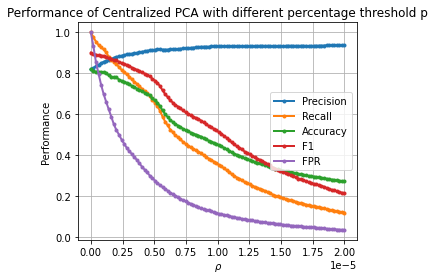

In [20]:
plt.figure(figsize=(5, 4));
plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
plt.xlabel(r'$\rho$')
plt.ylabel('Performance')
# plt.xticks(xticks)
# plt.legend(loc = 'lower right')
plt.legend()
plt.grid()
plt.title("Performance of Centralized PCA with different percentage threshold p")
# plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
plt.show()

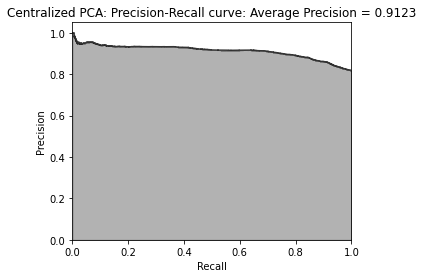

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])
average_precision = average_precision_score(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])

plt.figure(figsize=(5, 4));
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Centralized PCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
plt.show()

In [22]:
precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=0.000001, log=1)

Precision: 85.5581%
Recall: 91.677%
Accuracy score: 80.5031%
F1 score: 88.5119%
False alarm: 70.15%


### Standalone  PCA

In [23]:
df_test_raw = df_test.copy()
df_normal_train = df_train.copy()
num_users = 20
fraction  = int(df_normal_train.shape[0] / num_users)
fraction, df_test_raw.shape

(2800, (55332, 39))

In [24]:
df_normal_train = df_normal_train.sort_values(by=['ct_srv_src'])
df_normal_train = df_normal_train.reset_index(drop=True)
df_normal_train

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,1,1,1,1,0,0,0,1,1,0
1,1.076050,14,18,1684,10168,28.809069,31,29,1.162771e+04,71401.882810,...,4,1,1,1,0,0,1,2,3,0
2,1.005373,12,18,1580,10168,28.845016,31,29,1.153005e+04,76421.390630,...,3,1,1,1,0,0,1,1,2,0
3,0.001097,2,2,130,162,2734.731157,31,29,4.740201e+05,590701.937500,...,7,1,1,2,0,0,0,6,2,0
4,2.415148,52,54,2934,3742,43.475596,31,29,9.533163e+03,12166.541990,...,2,1,1,4,1,1,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,0.000010,2,0,1422,0,100000.002500,254,0,5.688000e+08,0.000000,...,9,9,1,63,0,0,0,9,62,0
55996,0.000009,2,0,452,0,111111.107200,254,0,2.008889e+08,0.000000,...,4,4,1,63,0,0,0,4,62,0
55997,0.000011,2,0,2158,0,90909.090200,254,0,7.847273e+08,0.000000,...,4,4,1,63,0,0,0,4,62,0
55998,0.000010,2,0,570,0,100000.002500,254,0,2.280000e+08,0.000000,...,6,6,1,63,0,0,0,6,62,0


In [25]:
#df_normal_train = df_train.copy()
avg_acc = 0
for i in range(20):
  df_train_stdPCA = df_normal_train[fraction*i:fraction*(i+1)].copy()
  df_train_client = df_train_stdPCA.copy()
  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train_client)
  df_test = pd.DataFrame(scaler.transform(df_test_raw))
  df_test.columns = df_test_abnormal.columns
  # Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train_client)
  _, df_test_PCA_inverse = perform_pca(df_train_client, df_test)

  abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

  df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
  df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score_PCA['anomalyScore'] = abnormal_score
  # plot_results(df_gt_score_PCA)

  # choose the right threshold
  lst_p = np.arange(0.4,0.8,0.001) # Among test, ratio of normal/abnormal = 0.75
  lst_rho = np.quantile(df_gt_score_PCA.anomalyScore, lst_p)
  optimal_p = 0.5
  optimal_rho = lst_rho[abs(lst_p - optimal_p)<1e-4][0]

  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=optimal_rho, log=1)
  avg_acc += accuracy_score
print(f"Average Accuracy: {100.0*avg_acc/20}")

(21, 39)
Precision: 99.1429%
Recall: 60.476%
Accuracy score: 67.1908%
F1 score: 75.1261%
False alarm: 2.37%


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(27, 39)
Precision: 98.4125%
Recall: 60.0326%
Accuracy score: 66.4624%
F1 score: 74.5742%
False alarm: 4.39%
(26, 39)
Precision: 99.1252%
Recall: 60.4915%
Accuracy score: 67.1944%
F1 score: 75.1329%
False alarm: 2.42%


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(27, 39)
Precision: 81.3236%
Recall: 49.6316%
Accuracy score: 49.3964%
F1 score: 61.6428%
False alarm: 51.67%
(26, 39)
Precision: 98.2614%
Recall: 59.9687%
Accuracy score: 66.3341%
F1 score: 74.4815%
False alarm: 4.81%


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(27, 39)
Precision: 98.4168%
Recall: 60.0635%
Accuracy score: 66.4896%
F1 score: 74.5993%
False alarm: 4.38%
(28, 39)
Precision: 96.0927%
Recall: 58.6451%
Accuracy score: 64.1654%
F1 score: 72.8376%
False alarm: 10.81%
(27, 39)


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Precision: 83.8584%
Recall: 51.1471%
Accuracy score: 51.9103%
F1 score: 63.5398%
False alarm: 44.63%
(25, 39)
Precision: 64.128%
Recall: 39.1357%
Accuracy score: 32.2002%
F1 score: 48.6075%
False alarm: 99.24%
(25, 39)


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Precision: 80.218%
Recall: 48.8683%
Accuracy score: 48.2361%
F1 score: 60.7364%
False alarm: 54.63%
(29, 39)
Precision: 99.1468%
Recall: 60.4981%
Accuracy score: 67.2107%
F1 score: 75.1442%
False alarm: 2.36%
(27, 39)


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Precision: 79.7828%
Recall: 48.6103%
Accuracy score: 47.806%
F1 score: 60.4123%
False alarm: 55.84%
(28, 39)
Precision: 98.5559%
Recall: 59.9179%
Accuracy score: 66.4426%
F1 score: 74.5267%
False alarm: 3.98%
(28, 39)


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Precision: 98.6588%
Recall: 60.2025%
Accuracy score: 66.7245%
F1 score: 74.776%
False alarm: 3.71%
(26, 39)
Precision: 81.4285%
Recall: 49.6956%
Accuracy score: 49.5012%
F1 score: 61.7222%
False alarm: 51.38%
(28, 39)


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Precision: 70.3788%
Recall: 42.952%
Accuracy score: 38.4515%
F1 score: 53.3467%
False alarm: 81.95%
(27, 39)
Precision: 95.4818%
Recall: 58.2723%
Accuracy score: 63.5545%
F1 score: 72.3746%
False alarm: 12.5%
(24, 39)


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Precision: 95.4457%
Recall: 58.2502%
Accuracy score: 63.5184%
F1 score: 72.3472%
False alarm: 12.6%
(25, 39)
Precision: 95.5503%
Recall: 58.312%
Accuracy score: 63.6214%
F1 score: 72.4249%
False alarm: 12.31%
(21, 39)
Precision: 86.2307%
Recall: 52.6207%
Accuracy score: 54.2995%
F1 score: 65.3579%
False alarm: 38.09%
Average Accuracy: 58.03549483120075


/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/tung6100/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
